In [1]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd

In [2]:
print("--- Step 1: Loading data and training baseline model ---")

# Load the pre-processed data
X_train = pd.read_csv("processed_data/train_features.csv")
y_train = pd.read_csv("processed_data/train_targets.csv")
X_test = pd.read_csv("processed_data/test_features.csv")
y_test = pd.read_csv("processed_data/test_targets.csv")

print(f"Original number of features: {X_train.shape[1]}")


--- Step 1: Loading data and training baseline model ---
Original number of features: 187


In [3]:
list(X_train)

['latitude',
 'longitude',
 't2m_min_mean',
 't2m_min_std',
 't2m_min_min',
 't2m_min_max',
 't2m_min_first',
 't2m_min_last',
 't2m_min_trend',
 't2m_min_recent_3d',
 't2m_max_mean',
 't2m_max_std',
 't2m_max_min',
 't2m_max_max',
 't2m_max_first',
 't2m_max_last',
 't2m_max_trend',
 't2m_max_recent_3d',
 't2m_mean_mean',
 't2m_mean_std',
 't2m_mean_min',
 't2m_mean_max',
 't2m_mean_first',
 't2m_mean_last',
 't2m_mean_trend',
 't2m_mean_recent_3d',
 'd2m_min_mean',
 'd2m_min_std',
 'd2m_min_min',
 'd2m_min_max',
 'd2m_min_first',
 'd2m_min_last',
 'd2m_min_trend',
 'd2m_min_recent_3d',
 'd2m_max_mean',
 'd2m_max_std',
 'd2m_max_min',
 'd2m_max_max',
 'd2m_max_first',
 'd2m_max_last',
 'd2m_max_trend',
 'd2m_max_recent_3d',
 'd2m_mean_mean',
 'd2m_mean_std',
 'd2m_mean_min',
 'd2m_mean_max',
 'd2m_mean_first',
 'd2m_mean_last',
 'd2m_mean_trend',
 'd2m_mean_recent_3d',
 'msl_min_mean',
 'msl_min_std',
 'msl_min_min',
 'msl_min_max',
 'msl_min_first',
 'msl_min_last',
 'msl_min_trend',

In [4]:
print("\n--- Step 2: Removing redundant component features ---")

# List of features to drop based on your feature engineering formulas
features_to_drop = [
    'es_d2m',          # Intermediate for RH and w
    'es_t2m',          # Intermediate for RH
    'u10_mean_mean',   # Component of wind_speed and wind_dir
    'v10_mean_mean',   # Component of wind_speed and wind_dir
    'w',               # Intermediate for Tv
    'msl_mean_trend',  # Duplicate of msl_tendency
    'd2m_mean_trend',  # Component of RH_trend
    't2m_mean_trend'   # Component of RH_trend
]

# Check which of these columns actually exist in the DataFrame to avoid errors
existing_cols_in_train = [col for col in features_to_drop if col in X_train.columns]
existing_cols_in_test = [col for col in features_to_drop if col in X_test.columns]

if not existing_cols_in_train:
    print("No specified features to drop were found in the training data.")
else:
    print(f"Dropping {len(existing_cols_in_train)} features: {existing_cols_in_train}")

    # Drop the columns from both training and testing sets
    X_train_final = X_train.drop(columns=existing_cols_in_train)
    X_test_final = X_test.drop(columns=existing_cols_in_test)

    print(f"\nNew number of features in X_train: {X_train_final.shape[1]}")
    print(f"New number of features in X_test: {X_test_final.shape[1]}")


--- Step 2: Removing redundant component features ---
Dropping 8 features: ['es_d2m', 'es_t2m', 'u10_mean_mean', 'v10_mean_mean', 'w', 'msl_mean_trend', 'd2m_mean_trend', 't2m_mean_trend']

New number of features in X_train: 179
New number of features in X_test: 179


In [5]:
# CELL 1: SETUP AND CONFIGURATION
# =============================================================================
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Configuration ---
# Set your desired correlation threshold for identifying highly correlated features
CORRELATION_THRESHOLD = 0.95
OUTPUT_FILENAME = "highly_correlated_features_report.txt"


# IMPORTANT: This script assumes your features DataFrame is already loaded
# and named 'X_train'. If it has a different name, change it below.
# For example: features_df = your_dataframe_name
features_df = X_train_final

print("Setup complete.")
print(f"Analyzing {features_df.shape[1]} features with a correlation threshold of {CORRELATION_THRESHOLD}.")

Setup complete.
Analyzing 179 features with a correlation threshold of 0.95.


In [6]:
print("\n--- Finding Highly Correlated Feature Pairs ---")

# Calculate the absolute correlation matrix
corr_matrix = features_df.corr().abs()

# Create a boolean mask for the upper triangle of the matrix to avoid duplicates
upper_triangle_mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

# Unstack the matrix to get a Series of all pairs, and apply the mask
all_corr_pairs = corr_matrix.where(upper_triangle_mask).stack()

# Filter to get only the pairs above the threshold
high_corr_pairs = all_corr_pairs[all_corr_pairs > CORRELATION_THRESHOLD]

# Sort the pairs for a clean, ranked view
sorted_pairs = high_corr_pairs.sort_values(ascending=False)

# --- Display the results in the notebook ---
print(f"\nFound {len(sorted_pairs)} feature pairs with a correlation greater than {CORRELATION_THRESHOLD}")

if not sorted_pairs.empty:
    print("\nTop 50 most correlated feature pairs:")
    # The display() function is ideal for showing DataFrames/Series nicely in notebooks
    display(sorted_pairs.head(50))
else:
    print("No highly correlated pairs were found at this threshold.")

# --- Save the full detailed list to a text file ---
print(f"\n--- Saving full report to '{OUTPUT_FILENAME}' ---")
try:
    with open(OUTPUT_FILENAME, 'w') as f:
        f.write(f"Detailed Report of Highly Correlated Feature Pairs\n")
        f.write(f"Correlation Threshold: > {CORRELATION_THRESHOLD}\n")
        f.write("="*60 + "\n\n")

        if sorted_pairs.empty:
            f.write("No feature pairs found above the specified threshold.\n")
            print("Report file created, but no pairs were found.")
        else:
            # Use to_string() to write the entire Series to the file without truncation
            report_string = sorted_pairs.to_string()
            f.write(report_string)
            print(f"Successfully saved all {len(sorted_pairs)} correlated pairs to the file.")
except IOError as e:
    print(f"Error: Could not write to file '{OUTPUT_FILENAME}'. Reason: {e}")


--- Finding Highly Correlated Feature Pairs ---

Found 243 feature pairs with a correlation greater than 0.95

Top 50 most correlated feature pairs:


t2m_mean_mean       Tv                    0.999986
msl_max_mean        msl_mean_mean         0.997294
msl_min_mean        msl_mean_mean         0.997062
day_of_year         month                 0.996684
msl_max_recent_3d   msl_mean_recent_3d    0.996227
msl_min_recent_3d   msl_mean_recent_3d    0.996148
msl_max_max         msl_mean_max          0.996018
msl_min_max         msl_mean_max          0.996007
msl_min_first       msl_mean_first        0.993559
msl_min_last        msl_mean_last         0.993509
msl_max_first       msl_mean_first        0.993434
msl_max_last        msl_mean_last         0.993364
tcc_min_std         tcc_min_max           0.992231
skt_mean_last       skt_mean_recent_3d    0.991760
skt_mean_mean       skt_mean_max          0.990983
                    Tv                    0.990729
t2m_mean_mean       skt_mean_mean         0.990708
msl_min_min         msl_mean_min          0.990526
msl_min_mean        msl_max_mean          0.990133
skt_mean_mean       skt_mean_re


--- Saving full report to 'highly_correlated_features_report.txt' ---
Successfully saved all 243 correlated pairs to the file.



--- Visualizing the Full Correlation Matrix ---
Computing and displaying the clustered heatmap... (this may take a minute)


/home/senhajiahmed/.local/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/senhajiahmed/.local/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


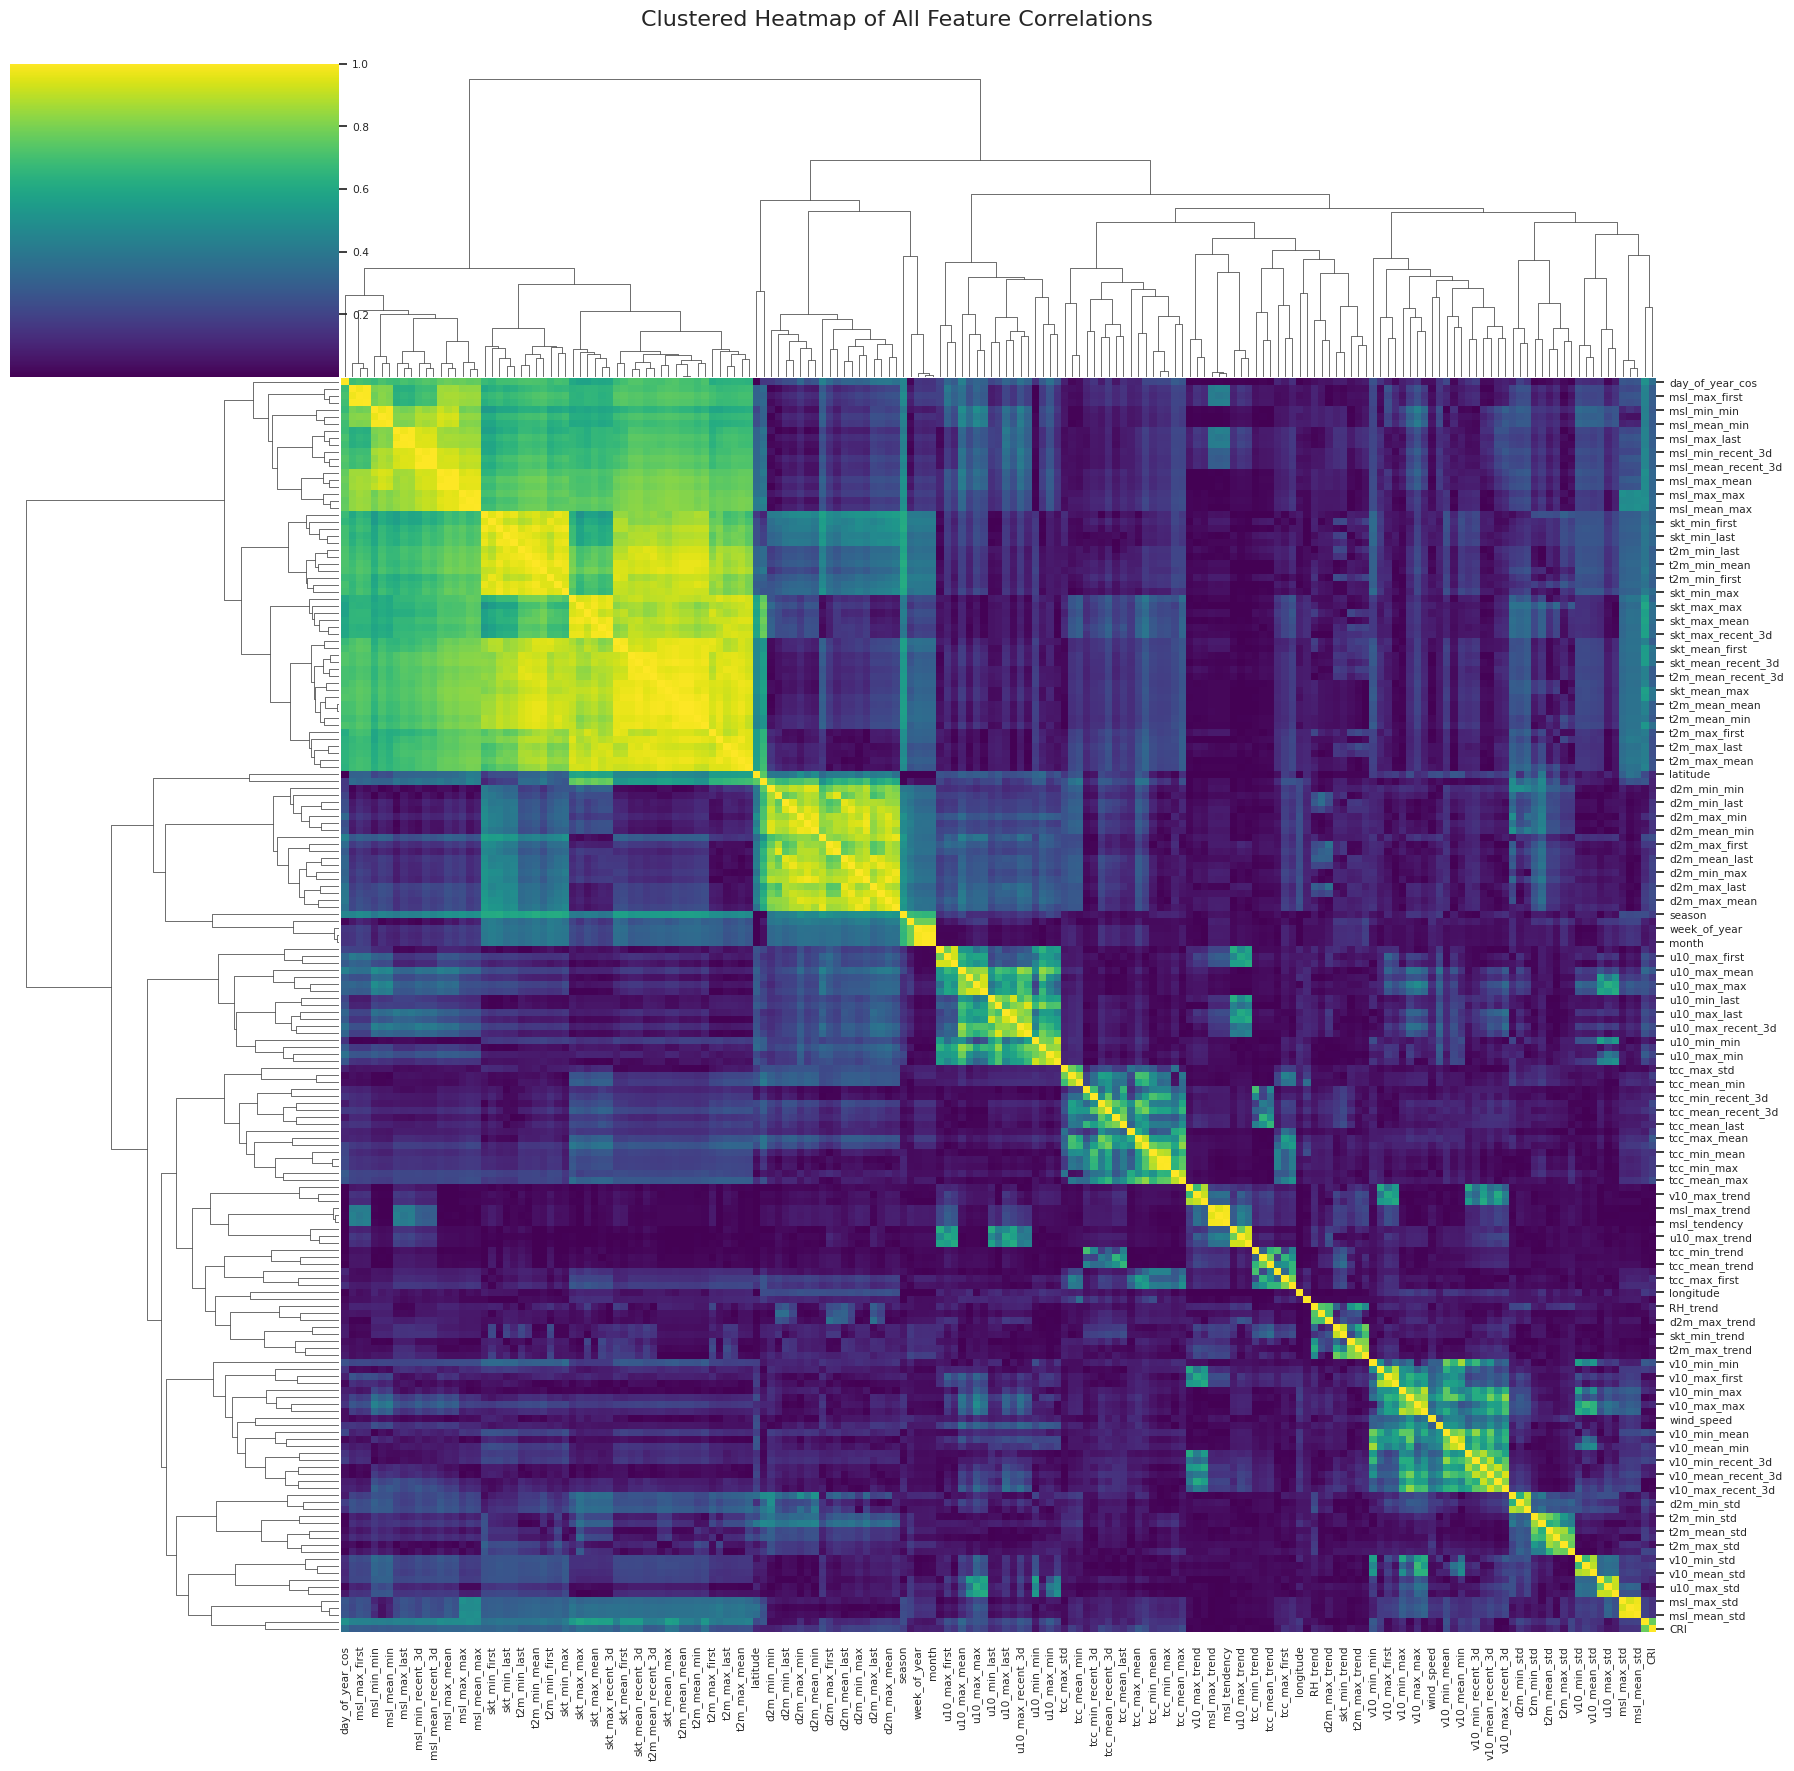

In [7]:
print("\n--- Visualizing the Full Correlation Matrix ---")
print("Computing and displaying the clustered heatmap... (this may take a minute)")

# Set default font size for better readability of labels
sns.set(font_scale=0.7)

# A clustered heatmap is the best way to visualize the structure in high dimensions.
# It reorders the features to group correlated ones together.
g = sns.clustermap(
    corr_matrix,
    cmap='viridis',        # A color-blind friendly and visually distinct colormap
    figsize=(18, 18)
)

# Add a title and adjust its position
g.fig.suptitle('Clustered Heatmap of All Feature Correlations', fontsize=16)
g.fig.subplots_adjust(top=0.95)

# Show the plot
plt.show()

In [8]:
# --- NEW: Systematically identify which features to drop ---
print("\n--- Creating a list of features to drop ---")
# Use the upper triangle of the original (non-sorted) correlation matrix
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find features with a correlation greater than the threshold
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > CORRELATION_THRESHOLD)]

print(f"Identified {len(to_drop)} features to remove.")
print("List of features to be dropped:", to_drop)

# --- NEW: Apply the changes to create reduced DataFrames ---
# We assume X_test is also loaded and has the same columns as X_train
# If not, you should load it here.
# X_test = pd.read_csv("processed_data/test_features.csv")

X_train_reduced = features_df.drop(columns=to_drop)
X_test_reduced = X_test_final.drop(columns=to_drop)

print("\n--- DataFrames with reduced features have been created ---")
print(f"Original number of features: {features_df.shape[1]}")
print(f"New number of features: {X_train_reduced.shape[1]}")
print("You can now use 'X_train_reduced' and 'X_test_reduced' to train your model.")



--- Creating a list of features to drop ---
Identified 65 features to remove.
List of features to be dropped: ['t2m_min_min', 't2m_min_max', 't2m_min_first', 't2m_min_last', 't2m_min_recent_3d', 't2m_max_min', 't2m_max_max', 't2m_max_first', 't2m_max_last', 't2m_max_recent_3d', 't2m_mean_mean', 't2m_mean_min', 't2m_mean_max', 't2m_mean_first', 't2m_mean_last', 't2m_mean_recent_3d', 'd2m_min_min', 'd2m_min_recent_3d', 'd2m_max_min', 'd2m_max_recent_3d', 'd2m_mean_mean', 'd2m_mean_min', 'd2m_mean_max', 'd2m_mean_first', 'd2m_mean_last', 'd2m_mean_recent_3d', 'msl_min_max', 'msl_max_mean', 'msl_max_min', 'msl_max_max', 'msl_max_first', 'msl_max_last', 'msl_max_trend', 'msl_max_recent_3d', 'msl_mean_mean', 'msl_mean_std', 'msl_mean_min', 'msl_mean_max', 'msl_mean_first', 'msl_mean_last', 'msl_mean_recent_3d', 'u10_mean_recent_3d', 'tcc_min_max', 'skt_min_mean', 'skt_min_min', 'skt_min_max', 'skt_min_first', 'skt_min_last', 'skt_min_recent_3d', 'skt_max_mean', 'skt_max_min', 'skt_max_max',

In [9]:
import os

# Get the number of CPU cores
num_cores = os.cpu_count()

print(f"This machine has {num_cores} cores.")

This machine has 12 cores.


In [10]:
print(f"Training data shape: {X_train_reduced.shape}")
print(f"Training target shape: {y_train.shape}")

Training data shape: (1143792, 114)
Training target shape: (1143792, 3)


In [19]:
list(y_train)

['t2m_min_next', 't2m_max_next', 't2m_mean_next']

In [24]:
# =============================================================================

# CELL 4: TRAIN AND EVALUATE A NEW MODEL ON THE REDUCED FEATURE SET

# =============================================================================

import pandas as pd

import numpy as np

import lightgbm as lgb

from sklearn.multioutput import MultiOutputRegressor

from sklearn.metrics import mean_absolute_error, r2_score

import time


print("\n--- Training a new model on the reduced feature set ---")


# --- Model Changed to LightGBM for Memory Efficiency ---

# 1. First, instantiate the base LightGBM model.

base_lgbm_model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=128,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)


# 2. FIXED: Wrap the base model with MultiOutputRegressor.

reduced_features_model = MultiOutputRegressor(base_lgbm_model)


# --- Train the model ---

print("\nFitting the LightGBM model...")

start_time = time.time()


# The fit method works exactly the same way

reduced_features_model.fit(X_train_reduced, y_train)

end_time = time.time()

training_time = end_time - start_time

print(f"Model training complete. Time taken: {training_time:.2f} seconds") 



--- Training a new model on the reduced feature set ---

Fitting the LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.273715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28411
[LightGBM] [Info] Number of data points in the train set: 1143792, number of used features: 114
[LightGBM] [Info] Start training from score 19.822301
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28411
[LightGBM] [Info] Number of data points in the train set: 1143792, number of used features: 114
[LightGBM] [Info] Start training from score 33.094938
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.220588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28411
[LightGBM] [Info] Num

In [27]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred_train = reduced_features_model.predict(X_train_reduced)
y_pred_test = reduced_features_model.predict(X_test_reduced)

print("\nTrain metrics:")
print("R2 (train):", r2_score(y_train, y_pred_train, multioutput='raw_values'))
print("MAE (train):", mean_absolute_error(y_train, y_pred_train))

print("\nTest metrics:")
print("R2 (test):", r2_score(y_test, y_pred_test, multioutput='raw_values'))
print("MAE (test):", mean_absolute_error(y_test, y_pred_test))



Train metrics:
R2 (train): [0.22847406 0.28408027 0.26353828]
MAE (train): 6.295729591294904

Test metrics:
R2 (test): [-0.78955383 -3.94836652 -2.83628873]
MAE (test): 9.086838904109749
